# Code for Euro Fouls and Frustration Fouls Blog

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
from pbpstats.resources.enhanced_pbp import Foul
from pbpstats.resources.enhanced_pbp import Turnover
from pbpstats.resources.enhanced_pbp import FieldGoal
from pbpstats.resources.enhanced_pbp import Rebound

fig_DIR = "../figs/pbp_related/"
source = "pbpstats"

In [2]:
def get_fouls(games_list):
    t = 5
    pos_store, TO_Miss_pID, TO_Miss_tID, Foul_pID,Foul_tID = [], [], [], [], []
    for game in tqdm(games_list):
        for possession in game.possessions.items:
            for possession_event in possession.events:
                if isinstance(possession_event, Foul) and (isinstance(possession_event.previous_event, Turnover) or  (isinstance(possession_event.previous_event, FieldGoal) and not possession_event.previous_event.is_made)) and possession_event.seconds_since_previous_event <= t:
                    pos_store.append(possession)
                    TO_Miss_pID.append(possession_event.previous_event.player1_id)
                    TO_Miss_tID.append(possession_event.previous_event.team_id)
                    Foul_pID.append(possession_event.player1_id)
                    Foul_tID.append(possession_event.team_id)
    return TO_Miss_pID,TO_Miss_tID,Foul_pID,Foul_tID

In [4]:
league = "NBA"
season_type = "Regular Season"
for year in range(2023,2024):
    print(year)
    if league == "NBA":
        season = str(year)+'-'+str(year+1)[-2:]
    else:
        season = str(year)
    if year >2021:
        data_provider = "data_nba"
    else:
        data_provider = "stats_nba"
    player_dict = get_players_pbp(league = league) # Creating Player Dictionary
    team_dict = teams.get_teams() # Creating Team Dictionary
    games_id = pbp_season(league=league,season_yr=str(year),season_type=season_type,data_provider=data_provider)
    games_list = pbp_games(games_id,data_provider=data_provider)
    TO_Miss_pID,TO_Miss_tID,Foul_pID,Foul_tID = get_fouls(games_list)
    EFoul_tID, EFoul_pID, FFoul_pID = [], [], []
    for i in range(len(TO_Miss_tID)):
        if TO_Miss_tID[i] == Foul_tID[i]:
            EFoul_tID.append(Foul_tID[i])
        if TO_Miss_pID[i] == Foul_pID[i]:
            EFoul_pID.append(Foul_pID[i])
        if TO_Miss_pID[i] == Foul_pID[i]:
            FFoul_pID.append(Foul_pID[i])
    data_euro = rank_data_pbp(EFoul_tID,player_dict,team_dict,sort="Team",var="Fouls")
    data_euro.to_csv(f"./fdata/NBA_Euro_fouls_{year}.csv",index=False)
    data_euroP = rank_data_pbp(EFoul_pID,player_dict,team_dict,sort="Player",var="Fouls")
    data_euroP.to_csv(f"./fdata/NBA_player_Euro_fouls_{year}.csv",index=False)
    data_frust = rank_data_pbp(FFoul_pID,player_dict,team_dict,sort="Player",var="Fouls")
    data_frust.to_csv(f"./fdata/NBA_player_Frustration_fouls_{year}.csv",index=False)
    games_list = []

2023
Number of games:  244


100%|██████████| 244/244 [00:16<00:00, 15.05it/s]


Number of bad games:  0


100%|██████████| 244/244 [00:00<00:00, 6240.91it/s]


In [2]:
dfa = {}
for year in range(2010,2024):
    dfa[year]  = pd.read_csv(f"./fdata/NBA_Euro_fouls_{year}.csv")
    dfa[year] = dfa[year].drop(columns = ["#"])

In [3]:
season_len = {
    2011:  1230,
    2012:  990,
    2013:  1230,
    2014:  1230,
    2015:  1230,
    2016:  1230,
    2017:  1230,
    2018:  1230,
    2019:  1230,
    2020:  1059,
    2021:  1080,
    2022:  1230,
    2023:  1230,
    2024:  244,
}

In [20]:
start_year = 2010
year = start_year
df = pd.merge(dfa[year],dfa[year+1],on="Team",suffixes=(f"_{year+1}",f"_{year+2}"))
for year in range(start_year+1,2023):
    df = pd.merge(df,dfa[year+1],on="Team",suffixes=(f"_{year+1}",f"_{year+2}"))
# df = df.rename(columns={"Fouls":"Fouls_2023"})
df.columns = df.columns.str.replace("Fouls_","")
df = df.set_index("Team")

In [21]:
dfT = df.T
dfT = dfT.reset_index()
dfT.columns = dfT.columns.to_list()
dfT = dfT.rename(columns={"index":"Year"})

In [22]:
total_fouls, fouls_PG = [], []
years = range(2013,2025)
for year in years:
    tfouls = df[f"{year}"].sum()
    total_fouls.append(tfouls)
    fouls_PG.append(tfouls/season_len[year])

In [52]:
df["2014-18"]=df.iloc[:,4:8].sum(axis=1)
df["2018-22"]=df.iloc[:,8:12].sum(axis=1)
df_agg = df.drop(df.iloc[:,:12],axis=1)
league = "NBA"

In [55]:
year = "2023"
title = "Euro Fouls "+ year
df1 = df_agg.sort_values(by=year,ascending=False).reset_index()
df1["#"] = df1.index +1
df1 = df1[["#","Team",year]]
fig = plot_table_rank(df1,year,sort="Team",title=title,source="pbpstats")
fig.write_image(fig_DIR+f"{league}_euro_foul_{year}.png", scale=3)

In [8]:
import seaborn as sns
sns.set_style("whitegrid")

Text(2022.5, 3100, 'Transition Take')

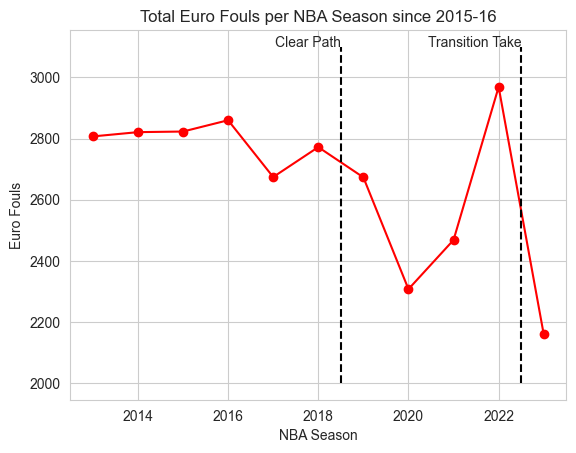

In [10]:
fig,ax = plt.subplots(1,1)
ax.plot(years[:-1],total_fouls[:-1],"o-",color="red")
ax.vlines(x=2019-0.5,ymin=2000,ymax=3100,linestyle="--",color="black")
ax.vlines(x=2023-0.5,ymin=2000,ymax=3100,linestyle="--",color="black")
ax.set_xlabel("NBA Season")
ax.set_ylabel("Euro Fouls")
ax.set_title("Total Euro Fouls per NBA Season since 2015-16")
ax.text(s="Clear Path",x=2018.5,y=3100,horizontalalignment="right")
ax.text(s="Transition Take",x=2022.5,y=3100,horizontalalignment="right")
# ax.set_xticks(range(2013,2024))

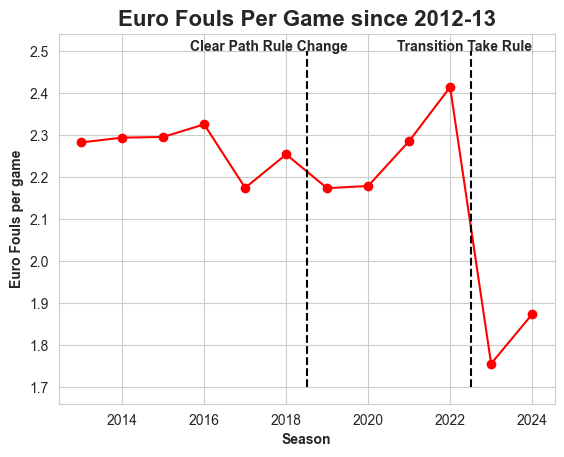

In [11]:
fig,ax = plt.subplots(1,1)
ax.plot(years,fouls_PG,"o-",color="red")
ax.vlines(x=2019-0.5,ymin=1.7,ymax=2.5,linestyle="--",color="black")
ax.vlines(x=2023-0.5,ymin=1.7,ymax=2.5,linestyle="--",color="black")
ax.set_xlabel("Season", weight='bold')
ax.set_ylabel("Euro Fouls per game", weight='bold')
ax.set_title("Euro Fouls Per Game since 2012-13",fontsize="16", weight='bold')
# ax.set_xticks(range(2013,2025))
ax.text(s="Clear Path Rule Change",x=2019.5,y=2.5,horizontalalignment="right", weight='bold')
ax.text(s="Transition Take Rule",x=2024,y=2.5,horizontalalignment="right", weight='bold')
plt.savefig(fig_DIR+"eurofouls_pergame.png",dpi=300)